# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [1]:
# all import statements needed for the project, for example:
# !pip install matplotlib
# !pip install requests
# !pip install bs4
# !pip install sqlalchemy
# !pip install pandas
# !pip install geojsonio --upgrade
# !pip install geopandas

# !pip install ipywidgets
# !pip install keplergl
# !jupyter nbextension install --py --sys-prefix keplergl
import pandas as pd
from keplergl import KeplerGl
import geopandas as gpd
import math
from math import *
import sqlite3
import sqlalchemy
from sqlalchemy.orm import sessionmaker
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
import sqlalchemy as db
import re
import datetime
import geojsonio
import numpy as np
import geopandas as gpd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 26.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for keplergl: filename=keplergl-0.3.2-py2.py3-none-any.whl size=17922322 sha256=7814208177a3d432b228f81e9fabe9e4d6bbeccb741c145dcda604fe8c721ccc
  Stored in directory: /Users/laurelhickey/Library/Caches/pip/wheels/15/7f/48/aa4980536f7c9fbc783b2a191a579e73e7f74c41afc3f33c61
Successfully built keplergl


In [2]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
# weather csv data file
# 2009_weather to 2015_weather (just pick the first 6 months)
csv__= '/Users/morax/Documents/哥大/IEORE4501/IEOR4501 HW/IEOR4501 Project/'
csv09_file = csv__ + '2009_weather.csv'
csv10_file = csv__ + '2010_weather.csv'
csv11_file = csv__ + '2011_weather.csv'
csv12_file = csv__ + '2012_weather.csv'
csv13_file = csv__ + '2013_weather.csv'
csv14_file = csv__ + '2014_weather.csv'
csv15_file = csv__ + '2015_weather.csv'

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Calculating distance
In this section in order to calculate the distance between two points in the uber data, we must use the longitude and latitude of the pickup and drop off locations.  Therefore, by using math module in order to calculate the distance between these two coordinates is given in the function calculate_distance().  Two different functions are written below using two different methods of calculating distance using the math module both with varying degrees of accuracy, in some situations the first method is more accurate than the second while in others the reverse is true.  It is important to note that, there are more accurate ways to calculate the distance based upon longitude and latitude that do not use just the math module.  In addtion, in the taxi data sets, the distance is already calculated, however, it is given in miles, so the miles_to_km() function converts the miles to kilometers so that a direct comparison between taxis and ubers can be made.  It should also be noted that the taxi distance is a distance driving on city streets whereas the uber distance is just a birdseye view distance, therefore, the distances in the taxi data set are likely to be slightly longer.  The function, add_distance_column() can be used in order to add the calculated distance to the uber data set.  This function uses the pickup and drop off longitudes and latitudes in order to build the additional column row by row.

In [3]:
def calculate_distance(from_coord, to_coord):
    # Longitude is x, Latitude is y, 
    # Longitude x
    long = (to_coord[0]-from_coord[0])*40000*math.cos((to_coord[1]+from_coord[1])*math.pi/360)/360
    # Latitude y
    lat = (to_coord[1]-from_coord[1])*40000/360
    # so the distance is just the side z followed by x^2+y^2=z^2
    distance = sqrt(long*long+lat*lat)
    return distance

from math import sin, cos, sqrt, atan2, radians
def calculate_distance2(from_coord, to_coord):
    # approximate radius of earth in km
    R = 6373.0

    # Longitude is x, Latitude is y, 
    # math.radians() converts a degree value into radians. 
    lon1 = radians(from_coord[0])
    lat1 = radians(from_coord[1])
    lon2 = radians(to_coord[0])
    lat2 = radians(to_coord[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# well sometime calculate_distance is better than calculate_distance2

In [4]:
def miles_to_km(distance_miles):
    distance_km = distance_miles /0.62137119
    return distance_km

In [5]:
# Need to fix the variable names called in lambda function
def add_distance_column(dataframe): 
    dataframe['Distance'] = dataframe.apply(lambda x: calculate_distance((x['pickup_longitude'], x["pickup_latitude"]), (x['dropoff_longitude'], x['dropoff_latitude'])),axis=1)


### Processing Taxi Data

In this section, the taxi data set is being processed, the first step in processing the taxi data is first finding the links, then once those links are found they must be read in, and processed by combining each dataset for each month and year into one larger dataset and changing the distance column from miles to kilometers.

-**get_taxi_html() and find_taxi_parquet_urls():** These functions are implementing web scraping in order to find the links for each data set of yellow taxi cabs. The first function, get_taxi_html(), is returning the html content of the web page that has the Taxi data. The second function, find_taxi_parquet_links is from the web page pulling out all of the links, then iterating through those links to see which are datasets for yellow taxi cabs from January 2009 to June 2015.

-**get_and_clean_month_taxi_data(url)** This function reads in the data for each month of each year.  In addition, this funciton also takes a sample of the dataset to match the size of the Uber's dataset.  This means that as the Uber dataset has 1.8 million data points if it is assumed that those data points are evenly distributed across the 78 months, each of the taxi datasets should have approximatly 23076.9 rows in it, therefore, each parquet file is randomly sampled to pick out 23080 rows.

-**zones_within_bbox()** This is a function that uses the taxi zone json file and using the centriod of the zone determines if that zone is within the bounding box (http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047).  If the zone is within the box it is included in the output list which is used later to remove data from some of the taxi files that do not have latitude and longitude included in their data.

-**get_and_clean_taxi_data()** This function concatinates all of the data for each month of each year into one large data set. In addition, it cleans the dataframe data types, removes any points that are outside of the bounding box (http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047) that is essentially the bounds of NYC and normalizes the column names in the files that are from 2009 to 2010 and 2011 to 2015 as they have slightly different names and variables.

In [6]:
def get_taxi_html():
    response = requests.get(TAXI_URL)
    html = response.content
    # check if the request was succeeded
    if not response.status_code == 200:
        return None
    return html


def find_taxi_parquet_urls():
    soup = bs4.BeautifulSoup(get_taxi_html(), 'html.parser')
    yellow_pattern = r"yellow_tripdata"
    # from Jan. 2009 to June 2015
    year_pattern = r"200\d{1}" # from Jan. 2009 to Dec. 2009
    year_pattern2 = r"201[01234]" # from Jan. 2010 to Dec.2014
    pattern2015 = r"2015-0[123456]" # from Jan. 2015 to June 2015
    link_list = [a['href'] for a in soup.find_all('a')[30:-25]]
    new_links = list()
    for item in link_list:
        # iterate through each year 2009 - 2015
        if (re.search(yellow_pattern, item) != None): 
            if (re.search(year_pattern, item) != None):
                new_links.append(item)
            if (re.search(year_pattern2, item) != None):
                new_links.append(item)
            if (re.search(pattern2015, item) != None):
                new_links.append(item)
    return new_links


In [7]:
def get_and_clean_month_taxi_data(url):
    dataframe = pd.read_parquet(url,engine='pyarrow')
    # Taking a sample of the taxi data:
    return dataframe.sample(n = 23080, random_state=39)


In [8]:
def miles_to_km(distance_miles):
    distance_km = distance_miles /0.62137119
    return distance_km

In [9]:
# This is Code in order to change the taxi zone to a latitude and longitude variable
def get_lat_and_long_from_zone(zone):
    import json
    from shapely.geometry import Point
    df = gpd.read_file('NYCTaxiZones.geojson')
    taxi_zones = gpd.GeoDataFrame(df)
    taxi_zones = taxi_zones.to_crs(4326)

    taxi_zones['lon'] = taxi_zones.centroid.x  
    taxi_zones['lat'] = taxi_zones.centroid.y
    

    for index,row in df.iterrows():
        if zone == row["location_id"]:
            long = row['lon']
            lat = row['lat']
            return lat, long


In [10]:
def zones_within_bbox():
    import json
    from shapely.geometry import Point
    df = gpd.read_file('NYCTaxiZones.geojson')
    taxi_zones = gpd.GeoDataFrame(df)
    taxi_zones = taxi_zones.to_crs(4326)
    taxi_zones['lon'] = taxi_zones.centroid.x  
    taxi_zones['lat'] = taxi_zones.centroid.y
    northlimit  = 40.908524
    southlimit = 40.560445
    eastlimit = -73.717047
    westlimit = -74.242330
    taxi_zones = taxi_zones[(taxi_zones["lon"] <= eastlimit) & (taxi_zones["lon"] >= westlimit)] 
    taxi_zones = taxi_zones[(taxi_zones["lat"] <= northlimit) & (taxi_zones["lat"]>= southlimit)]
    zones_in_range =list(taxi_zones["location_id"])
    return zones_in_range

In [11]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    all_csv_urls = find_taxi_parquet_urls()
    northlimit  = 40.908524
    southlimit = 40.560445
    eastlimit = -73.717047
    westlimit = -74.242330
    for csv_url in all_csv_urls:
        dataframe = get_and_clean_month_taxi_data(csv_url)
        # Making sure that the zone is in the [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
        if 'PULocationID' in dataframe.columns:
            dataframe[dataframe['PULocationID'].isin(zones_within_bbox())]
            dataframe[dataframe['DOLocationID'].isin(zones_within_bbox())]
            # Changing the distance column of each data set from miles to kilometers
            dataframe['trip_distance'] = dataframe.apply(lambda x: x["trip_distance"]/0.62137119, axis = 1)
            # Adding A Pickup Hour Column to the Data
            dataframe['pickup_hour'] = dataframe['tpep_pickup_datetime'].apply(lambda x:x.hour)
            # Removing Unnecessary Columns:
            dataframe = dataframe.drop(["VendorID","payment_type","airport_fee","mta_tax","store_and_fwd_flag","tolls_amount","congestion_surcharge","RatecodeID","extra","improvement_surcharge","fare_amount","passenger_count","total_amount"],axis=1)

            # Normalizing Column Names:
            dataframe.rename(columns ={"trip_distance": "distance", "tpep_pickup_datetime": "pickup_datetime","tpep_dropoff_datetime":"dropoff_datetime"}, inplace = True)
        elif "pickup_longitude" in dataframe.columns:
            # add_distance_column(dataframe)
            dataframe = dataframe[(dataframe["pickup_longitude"] <= eastlimit) & (dataframe["pickup_longitude"] >= westlimit)] 
            dataframe = dataframe [(dataframe ["pickup_latitude"] <= northlimit) & (dataframe["pickup_latitude"]>= southlimit)]
            dataframe  = dataframe[(dataframe["dropoff_longitude"] <= eastlimit) & (dataframe["dropoff_longitude"] >= westlimit)] 
            dataframe = dataframe[(dataframe["dropoff_latitude"] <= northlimit) & (dataframe["dropoff_latitude"]>= southlimit)]

            #Cleaning the date to make Datetime Object (already datetime object?)
            dataframe["dropoff_datetime"]  = dataframe["dropoff_datetime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe["pickup_datetime"]  = dataframe["pickup_datetime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe['pickup_hour'] = dataframe['pickup_datetime'].apply(lambda x:x.hour)

            dataframe = dataframe.drop(["vendor_id","payment_type","mta_tax","store_and_fwd_flag","surcharge","rate_code","tolls_amount","fare_amount","passenger_count","total_amount"], axis = 1)
            
            # Changing the distance column of each data set from miles to kilometers
            dataframe['trip_distance'] = dataframe.apply(lambda x: x["trip_distance"]/0.62137119, axis = 1)
            # Normalizing Column Names
            dataframe.rename(columns ={"trip_distance": "distance"}, inplace = True)

        elif "Trip_Pickup_DateTime" in dataframe.columns:

            dataframe.rename(columns ={"Start_Lon":"pickup_longitude","Start_Lat":"pickup_latitude","End_Lon":"dropoff_longitude","End_Lat":"dropoff_latitude"}, inplace = True)
            dataframe = dataframe[(dataframe["pickup_longitude"] <= eastlimit) & (dataframe["pickup_longitude"] >= westlimit)] 
            dataframe = dataframe [(dataframe ["pickup_latitude"] <= northlimit) & (dataframe["pickup_latitude"]>= southlimit)]

            dataframe  = dataframe[(dataframe["dropoff_longitude"] <= eastlimit) & (dataframe["dropoff_longitude"] >= westlimit)] 
            dataframe = dataframe[(dataframe["dropoff_latitude"] <= northlimit) & (dataframe["dropoff_latitude"]>= southlimit)]

            dataframe = dataframe.drop(["vendor_name","Total_Amt","Tolls_Amt","store_and_forward","mta_tax","surcharge","Fare_Amt","Payment_Type","Rate_Code","Passenger_Count"], axis = 1)
            dataframe["Trip_Pickup_DateTime"]  = dataframe["Trip_Pickup_DateTime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe["Trip_Dropoff_DateTime"]  = dataframe["Trip_Dropoff_DateTime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe['pickup_hour'] = dataframe["Trip_Pickup_DateTime"].apply(lambda x:x.hour)
            
            dataframe['distance'] = dataframe.apply(lambda x: x["Trip_Distance"]/0.62137119, axis = 1)

            dataframe.rename(columns ={"Tip_Amt":"tip_amount","Trip_Pickup_DateTime":"pickup_datetime","Trip_Dropoff_DateTime":"dropoff_datetime"}, inplace = True)

            dataframe = dataframe.drop(["Trip_Distance"],axis = 1)
        all_taxi_dataframes.append(dataframe)
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    #taxi_data = taxi_data.drop(["Distance"],axis = 1)
    
    return taxi_data

In [61]:
taxi_data.head(10)

,pickup_datetime,dropoff_datetime,distance,PULocationID,DOLocationID,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
10566313,2015-01-26 00:57:34,2015-01-26 01:06:47,3.862426,164.0,79.0,0,NaN,NaN,NaN,NaN
7100166,2015-01-17 21:43:25,2015-01-17 21:47:11,1.287475,234.0,90.0,21,NaN,NaN,NaN,NaN
332144,2015-01-01 20:37:28,2015-01-01 20:48:13,2.156521,142.0,161.0,20,NaN,NaN,NaN,NaN
841470,2015-01-03 10:43:15,2015-01-03 10:50:28,4.538350,229.0,148.0,10,NaN,NaN,NaN,NaN
6119963,2015-01-15 20:31:59,2015-01-15 20:36:17,1.303569,249.0,114.0,20,NaN,NaN,NaN,NaN
8807639,2015-01-22 06:50:02,2015-01-22 06:55:14,1.931213,239.0,142.0,6,NaN,NaN,NaN,NaN
3193240,2015-01-09 09:03:50,2015-01-09 09:20:19,2.735885,24.0,143.0,9,NaN,NaN,NaN,NaN
12323399,2015-01-31 07:50:47,2015-01-31 07:54:26,0.772485,164.0,170.0,7,NaN,NaN,NaN,NaN
4697863,2015-01-12 16:42:51,2015-01-12 17:21:29,9.495130,186.0,7.0,16,NaN,NaN,NaN,NaN
11030186,2015-01-28 10:37:55,2015-01-28 10:46:09,1.689811,237.0,162.0,10,NaN,NaN,NaN,NaN


In [63]:
for row in taxi_data['pickup_datetime']:
    taxi_data['year-month-day'] = date(row)
taxi_data

NameError: name 'date' is not defined

### Processing Uber Data

In this portion of the project, two functions load_and_clean_uber_data() and get_uber_data() are used.  The function load_and_clean_uber_data() reads in the uber data from a csv file and returns a dataframe.  The function get_uber_data() uses the previous function to read in the data, then uses the function add_distance_column previously defined in order to add the distance in kilometers of each trip taken by an uber in the dataset and returns the uber data as a dataframe.  In addition, some additional processing was done ot the data to convert the pickup_datetime into a datetime object and create a column for the day of the week the pickup occured on.  In addition any data that is outside of the bounding box (http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047) was removed.

In [12]:
def load_and_clean_uber_data(csv_file):
    return pd.read_csv(csv_file)

In [13]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    # Making Pickup_datetime a datetime object
    uber_dataframe["pickup_datetime"]  = uber_dataframe["pickup_datetime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S %Z'))
    uber_dataframe["day_of_week"]= uber_dataframe['pickup_datetime'].apply(lambda x: x.isoweekday())

    # Removing any data outside of the [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    #NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
    northlimit  = 40.908524
    southlimit = 40.560445
    eastlimit = -73.717047
    westlimit = -74.242330
    
    uber_dataframe = uber_dataframe[(uber_dataframe["pickup_longitude"] <= eastlimit) & (uber_dataframe["pickup_longitude"] >= westlimit)] 
    uber_dataframe = uber_dataframe [(uber_dataframe ["pickup_latitude"] <= northlimit) & (uber_dataframe["pickup_latitude"]>= southlimit)]

    uber_dataframe  = uber_dataframe[(uber_dataframe["dropoff_longitude"] <= eastlimit) & (uber_dataframe["dropoff_longitude"] >= westlimit)] 
    uber_dataframe = uber_dataframe[(uber_dataframe["dropoff_latitude"] <= northlimit) & (uber_dataframe["dropoff_latitude"]>= southlimit)]

    return uber_dataframe

### Processing Weather Data

In processing the weather data, two different dataframes (hourly_weather_data, daily_weather_data) were created.  The daily dataframe has data for each day from January 2009 to June 2015 and any duplicate measurment for the days is dropped.  In the hourly data, the data is broken down to each hour of each day from January 2009 to June 2015 and it drops any duplicate measurments that are taken in a given hour. 

In [14]:
def clean_month_weather_data_hourly(csv_file):
    # Just need to read in the data as a measurment is taken each hour 
    all_data = pd.read_csv(csv_file)

    # split data hourly
    date = all_data['DATE']
    import datetime
    date = date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))
    all_data['hours'] = date.apply(lambda x:x.hour)
    all_data['newDATE'] = 0
    for i in range(len(date)):
        all_data['newDATE'][i] = all_data['DATE'][i][:10]
    # now we have cleaned the data, now rename it
    hourly_data = all_data

    # you'll find which way to use in the later part
    # combine them all together and split into 24 rows
    # return clean_month_weather_data_hourly_all.drop_duplicates(subset=['hours'])

    # split values into 24 rows for each day
    return hourly_data.drop_duplicates(subset=['hours', 'newDATE'],keep='last')


In [15]:
def clean_month_weather_data_daily(csv_file):
    #need to combine rows for each given day
    all_data = pd.read_csv(csv_file)

    # split data daily
    date = all_data['DATE']
    import datetime
    date = date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))
    all_data['days'] = date.apply(lambda x:x.day)
    all_data['newDATE'] = 0
    for i in range(len(date)):
        all_data['newDATE'][i] = all_data['DATE'][i][:7]
    # now we have cleaned the data, now rename it
    daily_data = all_data

    # you'll find which way to use in the later part
    # combine them all together and split into 31 rows
    # return clean_month_weather_data_hourly_all.drop_duplicates(subset=['hours'])

    # split values into 31/30 rows for each month
    return daily_data.drop_duplicates(subset=['days', 'newDATE'],keep='last')
    

In [16]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []

    # add this at the beginnig
    # weather csv data file
    # 2009_weather to 2015_weather (just pick the first 6 months)
    csv__= '/Users/morax/Documents/哥大/IEORE4501/IEOR4501 HW/IEOR4501 Project/'
    csv09_file = csv__ + '2009_weather.csv'
    csv10_file = csv__ + '2010_weather.csv'
    csv11_file = csv__ + '2011_weather.csv'
    csv12_file = csv__ + '2012_weather.csv'
    csv13_file = csv__ + '2013_weather.csv'
    csv14_file = csv__ + '2014_weather.csv'
    csv15_file = csv__ + '2015_weather.csv'
    weather_csv09_14_files = [csv09_file, csv10_file, csv11_file, csv12_file, csv13_file, csv14_file]
    
    for csv_file in weather_csv09_14_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
    hourly_15_dataframe = clean_month_weather_data_hourly(csv15_file).iloc[:4344]
    hourly_dataframes.append(hourly_15_dataframe)
    daily_15_dataframe = clean_month_weather_data_daily(csv15_file).iloc[:181]
    daily_dataframes.append(daily_15_dataframe)

    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes).reset_index(drop=True)
    daily_data = pd.concat(daily_dataframes).reset_index(drop=True)
    
    return hourly_data, daily_data

### Process All Data

Once all of the functions in order to process the data have been written each of those functions can be executed.  Executing each of these functions, provides four clean data sets, taxi_data, uber_data, hourly_weather_data, and daily_weather_data.

In [ ]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [18]:
uber_data.head(10)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,day_of_week
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,1.682054,4
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2.455737,5
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,5.032581,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,1.660431,5
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,4.472077,4
5,44470845,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,6
6,48725865,2014-10-12 07:04:00.0000002,24.5,2014-10-12 07:04:00,-73.961447,40.693965,-73.871195,40.774297,5,11.722174,7
8,15822268,2012-02-17 09:32:00.00000043,9.7,2012-02-17 09:32:00,-73.975187,40.745767,-74.002720,40.743537,1,2.330953,5
9,50611056,2012-03-29 19:06:00.000000273,12.5,2012-03-29 19:06:00,-74.001065,40.741787,-73.963040,40.775012,1,4.885731,4
10,2205147,2015-05-22 17:32:27.0000004,6.5,2015-05-22 17:32:27,-73.974388,40.746952,-73.988586,40.729805,1,2.249161,5


In [60]:
taxi_data.head(10)

,pickup_datetime,dropoff_datetime,distance,PULocationID,DOLocationID,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
10566313,2015-01-26 00:57:34,2015-01-26 01:06:47,3.862426,164.0,79.0,0,NaN,NaN,NaN,NaN
7100166,2015-01-17 21:43:25,2015-01-17 21:47:11,1.287475,234.0,90.0,21,NaN,NaN,NaN,NaN
332144,2015-01-01 20:37:28,2015-01-01 20:48:13,2.156521,142.0,161.0,20,NaN,NaN,NaN,NaN
841470,2015-01-03 10:43:15,2015-01-03 10:50:28,4.538350,229.0,148.0,10,NaN,NaN,NaN,NaN
6119963,2015-01-15 20:31:59,2015-01-15 20:36:17,1.303569,249.0,114.0,20,NaN,NaN,NaN,NaN
8807639,2015-01-22 06:50:02,2015-01-22 06:55:14,1.931213,239.0,142.0,6,NaN,NaN,NaN,NaN
3193240,2015-01-09 09:03:50,2015-01-09 09:20:19,2.735885,24.0,143.0,9,NaN,NaN,NaN,NaN
12323399,2015-01-31 07:50:47,2015-01-31 07:54:26,0.772485,164.0,170.0,7,NaN,NaN,NaN,NaN
4697863,2015-01-12 16:42:51,2015-01-12 17:21:29,9.495130,186.0,7.0,16,NaN,NaN,NaN,NaN
11030186,2015-01-28 10:37:55,2015-01-28 10:46:09,1.689811,237.0,162.0,10,NaN,NaN,NaN,NaN


In [20]:
hourly_weather_data.head(10)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate,hours,newDATE
0,72505394728,2009-01-01T00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.01,3.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,0,2009-01-01
1,72505394728,2009-01-01T01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.03,3.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,1,2009-01-01
2,72505394728,2009-01-01T02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.07,3.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,2,2009-01-01
3,72505394728,2009-01-01T03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.09,3.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,3,2009-01-01
4,72505394728,2009-01-01T04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.12,3.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,4,2009-01-01
5,72505394728,2009-01-01T05:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.16,0.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,5,2009-01-01
6,72505394728,2009-01-01T06:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.20,0.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,6,2009-01-01
7,72505394728,2009-01-01T07:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.25,0.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,7,2009-01-01
8,72505394728,2009-01-01T08:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.26,0.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,8,2009-01-01
9,72505394728,2009-01-01T09:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.29,0.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,9,2009-01-01


In [21]:
daily_weather_data.head(10)

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate,days,newDATE
0,72505394728,2009-01-01T23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.22,1.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,1,2009-01
1,72505394728,2009-01-02T23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,O,NaN,NaN,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,2,2009-01
2,72505394728,2009-01-03T23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.08,9.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,3,2009-01
3,72505394728,2009-01-04T23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.00,12.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,4,2009-01
4,72505394728,2009-01-05T23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.03,3.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,5,2009-01
5,72505394728,2009-01-06T23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,O,NaN,NaN,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,6,2009-01
6,72505394728,2009-01-07T23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,O,NaN,NaN,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,7,2009-01
7,72505394728,2009-01-08T23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,29.73,16.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,8,2009-01
8,72505394728,2009-01-09T23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",AUTO,4,30.26,12.0,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,9,2009-01
9,72505394728,2009-01-10T23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,O,NaN,NaN,...,mi,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK ZOO,2006-09-18,10,2009-01


## Part 2: Storing Cleaned Data

Once the data was read and cleaned it is stored in a SQL database. In this portion, four tables (hourly_weather, daily_weather, taxi_trips, and uber_trips) were created to store the different dataframes data.

In [85]:
engine = db.create_engine(DATABASE_URL)
# First, using SQLAlchemy, create a SQLite database with which you’ll load in your preprocessed datasets.

In [86]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
    NAME TEXT,
    HourlyPrecipitation STRING,
    HourlyWindDirection STRING,
    HourlyWindGustSpeed STRING,
    HourlyWindSpeed	STRING,
    hours INTEGER,
    newDATE STRING
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
    NAME TEXT,
    DailyAverageWindSpeed STRING,
    DailyPeakWindDirection STRING,
    DailyPeakWindSpeed STRING,
    DailyPrecipitation STRING,
    DailySustainedWindDirection STRING,
    DailySustainedWindSpeed STRING,
    days INTEGER,
    newDATE STRING
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,	
    pickup_datetime	TIMESTAMP,
    dropoff_datetime DATE,
    distance FLOAT,
    PULocationID FLOAT,
    DOLocationID FLOAT,
    pickup_hour FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    fare_amount	FLOAT,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    passenger_count INTEGER,
    Distance FLOAT,
    day_of_week INTEGER
);
"""

In [87]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)


In [88]:
# create the tables with the schema files
with engine.connect() as connection:
    engine.connect().execute(
        HOURLY_WEATHER_SCHEMA
    )
    engine.connect().execute(
        DAILY_WEATHER_SCHEMA
    )
    engine.connect().execute(
        TAXI_TRIPS_SCHEMA
    )
    engine.connect().execute(
        UBER_TRIPS_SCHEMA
    )

pd.read_sql_query - read data from querying a SQL table

pd.read_sql_table - read entire SQL table

df.to_sql - add data from the dataframe to a SQL table

pd.to_numeric - Convert argument to a numeric type

pd.concat - Concatenate pandas objects along a particular axis with optional set logic along the other axes

pd.merge - Merge DataFrame or named Series objects with a database-style join

pd.merge_asof - Perform a merge by key distance. This is similar to a left-join except that we match on the nearest key rather than equal keys. Both DataFrames must be sorted by the key.

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [89]:
def write_dataframes_to_table(table_to_df_dict):
    for item_0, item_1 in table_to_df_dict.items():
        # add data from the dataframe to a SQL table
        item_1.to_sql(item_0, engine, index_label="id", if_exists="append", index=True)

In [90]:
#add several col.s of taxi data before add it to the tabel

In [91]:
# clean data to pick useful columns and ignore others
taxi_data_clean = taxi_data.set_index([pd.Series(np.arange(len(taxi_data['distance'])))])  
uber_data_clean = uber_data.iloc[:,2:11]
hourly_data = hourly_weather_data.iloc[:, [1,2,3,5,11,21,22,23,-2,-1]]
daily_data = daily_weather_data.iloc[:, [1,2,3,5,32,38,39,40,43,44,-2,-1]]

In [92]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data_clean,
    "uber_trips": uber_data_clean,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
}

In [93]:
write_dataframes_to_table(map_table_name_to_dataframe)

In [94]:
!sqlite3 project.db < schema.sql

In [59]:
# pd.read_sql_table("daily_weather", con=DATABASE_URL).iloc[1850:2000,:]

In [ ]:
# pd.read_sql_table("uber_trips", con=DATABASE_URL)

## Part 3: Understanding the Data

In this section, six queries are done to the SQL tables in order to determine the following information about taxi and uber trips:
* For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* What is the 95% percentile of distance traveled for all hired trips during July 2013?
* What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [ ]:
# For each query, be sure to execute it in the notebook

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [x] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [x] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [no uber now] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ][x] Which 10 days in 2014 were the windiest, []and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [ ]:
# Tips
# You may wish to use SQLAlchemy within the notebook to help craft these queries and query files. 
# You can also use pandas to help check the validity of your queries.
# You may want to familiarize yourself with the WITH <name> AS and WITH RECURSIVE <name> AS expressions in SQL. 
# This is a good resource with a lot of examples to help get familiar.
# There are quite a few examples using UNION ALL - this will help "flatten" tables that have common columns 
# (e.g. fare amount, pickup dates, etc) into a singular shared column (for example, taxi fares and uber fares are in one column).
# Look at the example query that starts with WITH RECURSIVE dates(x) AS for help with the 6th query.
# You may also want to familiarize yourself with the COALESCE expression in SQL. This is a decent tutorial to look through.
# This Stack Overflow post will be helpful when crafting queries for figuring out percentiles/quantiles.
# This Stack Overflow post will be helpful for grouping results by timeframe, e.g. by hour, day.

In [139]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as o:
        o.write(query)


### For the same time frame, what day of the week was the most popular to take an uber? 
In this portion, in order to determine the most popular day of the week for uber trips, the number of times a certain day of week appears in the dataset is counted and then ordered by days of that count. 


From the output, we find Friday is the most popular day to take an uber among the week.


In [140]:
# def uber_popular_day_of_week(df = uber_data):
     
#      day_of_week_group = df.groupby('day_of_week').size().sort_values(ascending=False)
#      return day_of_week_group

# uber_popular_day_of_week()
Uber_day_most_pop = """
    SELECT day_of_week FROM uber_trips GROUP BY day_of_week ORDER BY COUNT(day_of_week) DESC
"""

In [141]:
engine.execute(Uber_day_most_pop).fetchall()
# Friday is the most popular day

[(5,), (6,), (4,), (3,), (2,), (7,), (1,)]

In [142]:
# testing
result = engine.execute(Uber_day_most_pop).fetchall()
for row in result:
    print(row)

(5,)
(6,)
(4,)
(3,)
(2,)
(7,)
(1,)


In [143]:
write_query_to_file(Uber_day_most_pop, "Uber_most_pop_day.sql")

### Most Popular Hour Taxis Query

_**TODO:**  In this section, in order to determine the post popular hour for a taxi pickup to occur at, the number of times a pickup hour occurs in the database is counted, then it is ordered by that count.

We find out the most popular hour of pickup is 7p.m..

In [144]:
taxi_hour_most_pop = """
    SELECT pickup_hour, COUNT(pickup_hour) FROM taxi_trips GROUP BY pickup_hour ORDER BY COUNT(pickup_hour) DESC
    """

In [145]:
engine.execute(taxi_hour_most_pop).fetchall()
# The most popular hour for a tzxi pickup to occur is at 19(same as 7p.m.).

[(19.0, 111676),
 (18.0, 107562),
 (20.0, 105567),
 (21.0, 102491),
 (22.0, 99690),
 (14.0, 90793),
 (23.0, 88970),
 (17.0, 88767),
 (12.0, 87899),
 (13.0, 87399),
 (15.0, 85954),
 (9.0, 83415),
 (11.0, 82853),
 (8.0, 81141),
 (10.0, 79896),
 (16.0, 74176),
 (0.0, 71349),
 (7.0, 64168),
 (1.0, 52371),
 (2.0, 39011),
 (6.0, 36858),
 (3.0, 28697),
 (4.0, 21088),
 (5.0, 17558)]

In [146]:
write_query_to_file(taxi_hour_most_pop, "Taxi_hour_most_pop.sql")

### What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
_**TODO:** Write some prose that tells the reader what you're about to do here.


Those are what we found: (top 10 days, number of hired rides, average distance)
* ('2009-01-24', 954, 4.144043945487254), 
* ('2009-02-06', 950, 3.954700317060508),
* ('2009-02-13', 942, 4.41544541717232),
* ('2009-02-20', 937, 4.269175717911793),
* ('2009-12-18', 932, 4.236252742463521),
* ('2009-11-07', 928, 4.112689012049695),
* ('2009-02-14', 922, 4.161969567089876),
* ('2009-06-05', 910, 4.084019903935855),
* ('2009-09-10', 909, 4.2768361215379675),
* ('2009-02-05', 909, 3.9356516513985897)

In [147]:
top_10_days_2009 = """
SELECT DATE(pickup_datetime), COUNT(DATE(pickup_datetime)), AVG(distance)
FROM taxi_trips 
WHERE pickup_datetime LIKE '2009-%-%'
GROUP BY DATE(pickup_datetime) 
ORDER BY COUNT(DATE(pickup_datetime)) DESC
LIMIT 10
"""

In [148]:
engine.execute(top_10_days_2009).fetchall()
# TOP 10 days, no. of rides, average distance

[('2009-01-24', 954, 4.144043945487254),
 ('2009-02-06', 950, 3.954700317060508),
 ('2009-02-13', 942, 4.41544541717232),
 ('2009-02-20', 937, 4.269175717911793),
 ('2009-12-18', 932, 4.236252742463521),
 ('2009-11-07', 928, 4.112689012049695),
 ('2009-02-14', 922, 4.161969567089876),
 ('2009-06-05', 910, 4.084019903935855),
 ('2009-09-10', 909, 4.2768361215379675),
 ('2009-02-05', 909, 3.9356516513985897)]

In [149]:
write_query_to_file(top_10_days_2009, "top_10_days_2009.sql")

### Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
_**TODO:** Write some prose that tells the reader what you're about to do here.


In [150]:
# weather data below
# 5. Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

windiest_days= """
SELECT DATE, DailyAverageWindSpeed
FROM daily_weather
WHERE DATE LIKE '2014-%-%' 
ORDER BY DailyAverageWindSpeed DESC 
LIMIT 10
"""

In [151]:
engine.execute(windiest_days).fetchall()

[('2014-03-13T23:59:00', 14.1),
 ('2014-01-07T23:59:00', 13.1),
 ('2014-02-13T23:59:00', 12.6),
 ('2014-01-02T23:59:00', 12.2),
 ('2014-03-26T23:59:00', 11.9),
 ('2014-12-07T23:59:00', 11.8),
 ('2014-12-08T23:59:00', 11.5),
 ('2014-03-29T23:59:00', 10.8),
 ('2014-11-02T23:59:00', 10.8),
 ('2014-01-03T23:59:00', 10.4)]

In [152]:
write_query_to_file(windiest_days, "windiest_days.sql")

### What is the 95% percentile of distance traveled for all hired trips during July 2013?
_**TODO:** Write some prose that tells the reader what you're about to do here._


In [ ]:
distance_95th_2013 ="""

"""

In [ ]:
engine.execute(distance_95th_2013).fetchall()

In [ ]:
write_query_to_file(distance_95th_2013, "95th_distance_2013.sql")

### During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

_**TODO:** Write some prose that tells the reader what you're about to do here._


In [ ]:
# 6. During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, 
# and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? 
# There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

sandy = """ 

"""

In [ ]:
engine.execute(sandy).fetchall()

In [ ]:
write_query_to_file(sandy, "Sandy.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [x] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization: For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? 
_**TODO:** Write some prose that tells the reader what you're about to do here._


In [207]:
def plot_visual_taxi_hour(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = dataframe['pickup_hour']  # use the dataframe to pull out values needed to plot
    counts = dataframe['COUNT(pickup_hour)']
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    # axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # axes.plot(values, counts)
    plt.bar(values, counts)
    # and set up axes labels, etc
    axes.set_title("Most Popular Hour of the Day to take a Yellow Taxi January 2009 to June 2015")
    
    plt.show()

In [209]:
# get_data_for_visual_taxi_hour()

In [189]:
def get_data_for_visual_taxi_hour():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish

    # Read the sql file
    query = open('Taxi_hour_most_pop.sql', 'r')
    # connection == the connection to your database, in your case prob_db
    data = pd.read_sql_query(query.read(),DATABASE_URL)
    return data

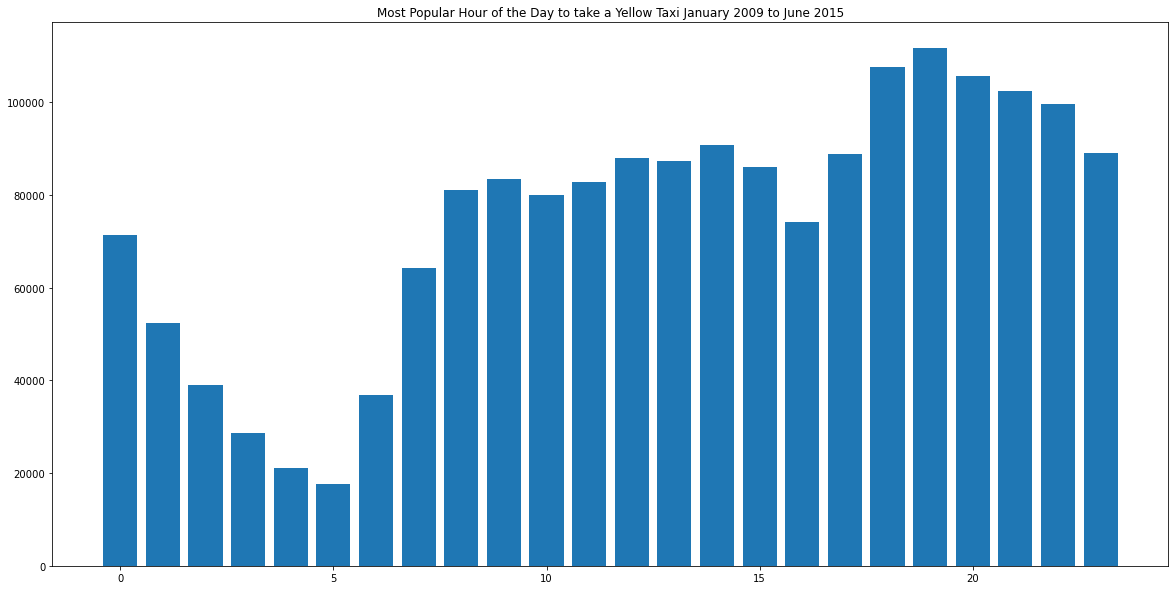

In [208]:
taxi_hour_most_pop = get_data_for_visual_taxi_hour()
plot_visual_taxi_hour(taxi_hour_most_pop)


### Visualization: Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR. Compares what day of the week was most popular for drop offs for each airport.
_**TODO:** Write some prose that tells the reader what you're about to do here._


EWR (Newark): -74.195995,40.664103,-74.148445,40.713045

JFK: -73.832496,40.618362,-73.744262,40.669421

LGA (LaGuardia): -73.892010,40.764638,-73.852357,40.787711

In [ ]:
# needs to be fixed up for our purposes
# Just looking at uber data?????
def get_zone(lon,lat,airport_boxes):
    
    #MY CODE STARTS HERE
    # long is x lat is y 
    
    for item in airport_boxes:
        #print(item)
        if (item[1][0][0] <= lon <= item[1][1][0]) & (item[1][0][1] <= lat <= item[1][2][1]):
            zone = item[0]
            # want to return airport name 
        else:
            # want to return na if no airport name
            break

df['dropoff_zone'] = df.apply(lambda x: get_zone(x["dropoff_longitude"], x["dropoff_latitude"], zone_table),axis =1)
        

In [ ]:
def plot_visual_hour_of_day(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_n():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplemented()

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)

### Visualization:  A heatmap of all hired trips over a map of the area

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [ ]:
def plot_visual_heatmap(dataframe):

    map = KeplerGl(height=600, width=800)
    gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.Longitude, dataframe.Latitude))
    map.add_data(data=gdf, name="Hired Trips")
    
    map

In [ ]:
def get_data_for_visual_heatmap():
    query = "SELECT pickup_longitude, pickup_latitude FROM ubertrips"
    data = pd.dataframe(engine.execute(query).fetchall(),columns = ['Longitude','Latitude'])
    return data

In [ ]:
heatmap_dataframe = get_data_for_visual_map()
plot_visual_heatmap(heatmap_dataframe)

### Visualization: The average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

### Visualization:  A scatter plot that compares tip amount versus precipitation amount
Comparing Tip amount for taxis to the amount of precipitation at the time of the ride.

In [ ]:
def plot_visual_tip_vs_preciptitation(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Preciptitation vs Tip Amount")
    
    plt.show()

In [ ]:
def get_data_for_visual_tip_vs_preciptiation():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    query = ""
    data = pd.dataframe(engine.execute(query).fetchall(),columns = ['Tip Amount','Distance'])
    return data
    

In [ ]:
tip_vs_preciptitation_dataframe = get_data_for_visual_tip_vs_preciptiation()
plot_visual_tip_vs_preciptitation(tip_vs_preciptitation_dataframe)

### Visualization:  A scatter plot that compares tip amount versus distance
Below is a plot that compares the distance traveled to the tip amount recieved by taxi drivers in the NYC area.

In [ ]:
def plot_visual_hour_of_day(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = dataframe['Distance'] # use the dataframe to pull out values needed to plot
    tip = dataframe['Tip Amount']
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    plt.scatter(values, tip, marker='o')
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_distance_tip():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    query = "SELECT tip_amount, distance from taxi_trips"
    data = pd.dataframe(engine.execute(query).fetchall(),columns = ['Tip Amount','Distance'])
    return data


In [ ]:
distance_tip_dataframe = get_data_for_visual_distance_tip()
plot_visual_tip_distance(distance_tip_dataframe)

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_n():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplemented()

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)